#### Central Difference

https://en.wikipedia.org/wiki/Finite_difference



In [1]:
# try:
#     import blackjax
# except ModuleNotFoundError:
#     %pip install -qq jaxopt blackjax
#     import blackjax
import jax
import jax.numpy as jnp
import jax.scipy as jscipy

from jax.scipy import stats as sp_stats
from functools import partial
from jax import jit, lax
from jax.flatten_util import ravel_pytree
from jax.random import normal
from typing import Any, Callable, NamedTuple, Union, Protocol, Optional
from blackjax.types import ArrayLikeTree, ArrayTree, PRNGKey, Array

Position = ArrayLikeTree
State = NamedTuple
Info = NamedTuple

class InitFn(Protocol):
    def __call__(self, position: Position, rng_key: Optional[PRNGKey]) -> State:
        ...

class UpdateFn(Protocol):
    def __call__(self, rng_key: PRNGKey, state: State) -> tuple[State, Info]:
        ...

class SamplingAlgorithm(NamedTuple):
    init: InitFn
    step: UpdateFn

@partial(jit, static_argnames=("precision",), inline=True)
def linear_map(diag_or_dense_a, b, *, precision="highest"):
    dtype = jnp.result_type(diag_or_dense_a.dtype, b.dtype)
    diag_or_dense_a = diag_or_dense_a.astype(dtype)
    b = b.astype(dtype)
    ndim = jnp.ndim(diag_or_dense_a)

    if ndim <= 1:
        return lax.mul(diag_or_dense_a, b)
    else:
        return lax.dot(diag_or_dense_a, b, precision=precision)

def generate_gaussion_noise(rng_key: PRNGKey, position: ArrayLikeTree, mu: Union[float, Array] = 0.0, sigma: Union[float, Array] = 1.0) -> ArrayTree:
    p, unravel_fn = ravel_pytree(position)
    sample = normal(rng_key, shape=p.shape, dtype=p.dtype)
    return unravel_fn(mu + linear_map(sigma, sample))

# template of kinetic energy
class KineticEnergy(Protocol):
    def __call__(self, momentum: ArrayLikeTree, position: Optional[ArrayLikeTree] = None) -> float:
        ...

class CheckTurning(Protocol):
    def __call__(self, momentum_left: ArrayLikeTree, momentum_right: ArrayLikeTree, momentum_sum: ArrayLikeTree, position_left: Optional[ArrayLikeTree] = None, position_right: Optional[ArrayLikeTree] = None) -> bool:
        ...

class Metric(NamedTuple):
    sample_momentum: Callable[[PRNGKey, ArrayLikeTree], ArrayLikeTree]
    kinetic_energy: KineticEnergy
    checking_turning: CheckTurning

MetricTypes = Union[Metric, Array, Callable[[ArrayLikeTree], Array]]

def gaussian_euclidean(inverse_mass_matrix: Array) -> Metric:
    ndim = jnp.ndim(inverse_mass_matrix)
    shape = jnp.shape(inverse_mass_matrix)[:1]
    # print(f'inverse_mass_matrix , ndim : {ndim} shape : {shape}')
    if ndim == 1: # diagonal mass matrix
        print('ndim : 1')
        mass_matrix_sqrt = jnp.sqrt(jnp.reciprocal(inverse_mass_matrix))
        matmul = jnp.multiply
    elif ndim == 2:
        print('ndim : 2')
        L = jscipy.linalg.cholesky(inverse_mass_matrix, lower=True)
        identity = jnp.identity(shape[0])
        mass_matrix_sqrt = jscipy.linalg.solve_triangular(L,identity,lower=True,trans=True)
        matmul = jnp.matmul
    else: 
        raise ValueError("The mass matirix has the wrong number of dimensions:"
                         f" expected 1 or 2. got {ndim}.")
    
    def momentum_generator(rng_key: PRNGKey, position: ArrayLikeTree) -> ArrayTree:
        return generate_gaussion_noise(rng_key, position, sigma=mass_matrix_sqrt)
    
    def kinetic_energy(momentum: ArrayLikeTree, position: Optional[ArrayLikeTree] = None) -> float:
        del position
        momentum,_ = ravel_pytree(momentum)
        velocity = matmul(inverse_mass_matrix, momentum)
        kinetic_energy_val = 0.5*jnp.dot(velocity, momentum)
        return kinetic_energy_val

    def is_turning(momentum_left: ArrayLikeTree, momentum_right: ArrayLikeTree, momentum_sum: ArrayLikeTree, position_left: Optional[ArrayLikeTree] = None, position_right: Optional[ArrayLikeTree] = None) -> bool:
        del position_left, position_right
        m_left = ravel_pytree(momentum_left)
        m_right = ravel_pytree(momentum_right)
        m_sum, _ = ravel_pytree(momentum_sum)

        velocity_left = matmul(inverse_mass_matrix, m_left)
        velocity_right = matmul(inverse_mass_matrix, m_right)

        # rho = m_sum
        rho = m_sum - (m_right + m_left) / 2
        turning_at_left = jnp.dot(velocity_left, rho) <= 0
        turning_at_right = jnp.dot(velocity_right, rho) <= 0
        return turning_at_left | turning_at_right
    
    return Metric(momentum_generator, kinetic_energy, is_turning)

def gaussian_riemannian(mass_matrix_fn: Callable) -> Metric:
    def momentum_generator(rng_key: PRNGKey, position: ArrayLikeTree) -> ArrayLikeTree:
        mass_matrix = mass_matrix_fn(position)
        ndim = jnp.ndim(mass_matrix)
        if ndim == 1:
            mass_matrix_sqrt = jnp.sqrt(mass_matrix)
        elif ndim == 2:
            mass_matrix_sqrt = jscipy.linalg.cholesky(mass_matrix, lower=True)
        else:
            raise ValueError("The mass matrix has the wrong number of dimensions:"
                             f" expected 1 or 2, got {jnp.ndim(mass_matrix)}.")
        return generate_gaussion_noise(rng_key, position, sigma=mass_matrix_sqrt)
    
    def kinetic_energy(momentum: ArrayLikeTree, position: Optional[ArrayLikeTree] = None) -> float:
        if position is None:
            raise ValueError("A Reinmannian kinetic energy function must be called with the "
                             "position specified; make sure to use a Reinmannian-capable "
                             "integrator like `implicit_midpoint`.")
        momentum, _ = ravel_pytree(momentum)
        mass_matrix = mass_matrix_fn(position)
        ndim = jnp.ndim(mass_matrix)
        if ndim == 1:
            return -jnp.sum(sp_stats.norm.logpdf(momentum, 0.0, jnp.sqrt(mass_matrix)))
        elif ndim == 2:
            return -sp_stats.multinomial.logpdf(momentum, jnp.zeros_like(momentum, mass_matrix))
        else:
            raise ValueError("The mass matrix has the wrong number of dimensions:"
                             f" expected 1 or 2, got {jnp.ndim(mass_matrix)}.")

    def is_turning(momentum_left: ArrayLikeTree, momentum_right: ArrayLikeTree, momentum_sum: ArrayLikeTree, position_left: Optional[ArrayLikeTree] = None, position_right: Optional[ArrayLikeTree] = None) -> bool:
        del momentum_left, momentum_right, momentum_sum, position_left, position_right
        raise NotImplementedError("NUTS sampling is not yeh implemented for Riemannian manifolds")
        # needs implementation
        # Here's a possible implementation of this function, but the NUTS
        # proposal will require some refactoring to work properly, since we need
        # to be able to access the coordinates at the left and right endpoints
        # to compute the mass matrix at those points.

        # m_left, _ = ravel_pytree(momentum_left)
        # m_right, _ = ravel_pytree(momentum_right)
        # m_sum, _ = ravel_pytree(momentum_sum)

        # mass_matrix_left = mass_matrix_fn(position_left)
        # mass_matrix_right = mass_matrix_fn(position_right)
        # velocity_left = jnp.linalg.solve(mass_matrix_left, m_left)
        # velocity_right = jnp.linalg.solve(mass_matrix_right, m_right)

        # # rho = m_sum
        # rho = m_sum - (m_right + m_left) / 2
        # turning_at_left = jnp.dot(velocity_left, rho) <= 0
        # turning_at_right = jnp.dot(velocity_right, rho) <= 0
        # return turning_at_left | turning_at_right
    return Metric(momentum_generator, kinetic_energy, is_turning)

def default_metric(metric: MetricTypes) -> Metric:
    # print(type(metric), f'{isinstance(metric, Metric)}, {callable(metric)}')
    if isinstance(metric, Metric):
        return metric
    if callable(metric):
        #RM-HMC
        return gaussian_riemannian(metric)
    return gaussian_euclidean(metric)

class IntegratorState(NamedTuple):
    position: ArrayTree
    momentum: ArrayTree
    logdensity: float
    logdensity_grad: ArrayTree

Integrator = Callable[[IntegratorState, float], IntegratorState]

def euclidean_position_update_fn(logdensity_fn: Callable):
    logdensity_and_grad_fn = jax.value_and_grad(logdensity_fn)

    def update(position: ArrayTree, kinetic_grad: ArrayTree, step_size: float, coef: float, auxiliary_info=None):
        del auxiliary_info
        new_position = jax.tree_util.tree_map(lambda x, grad: x + step_size*coef*grad, position, kinetic_grad)
        logdensity, logdensity_grad = logdensity_and_grad_fn(new_position)
        return new_position, logdensity, logdensity_grad, None
    
    return update

def euclidean_momentum_update_fn(kinetic_energy_fn: KineticEnergy):
    kinetic_energy_grad_fn = jax.grad(kinetic_energy_fn)

    def update(momentum: ArrayTree, logdensity_grad: ArrayTree, step_size: float, coef: float, auxiliary_info=None, is_last_call=False):
        del auxiliary_info
        new_momentum = jax.tree_util.tree_map(lambda x, grad: x + step_size*coef*grad, momentum, logdensity_grad)
        if is_last_call:
            return new_momentum, None, None
        kinetic_grad = kinetic_energy_grad_fn(new_momentum)
        return new_momentum, kinetic_grad, None
    
    return update

# operator1 -> momentum update
# operator2 -> position update
def generalized_two_stage_integrator(operator1: Callable, operator2: Callable, coefficients: list[float], format_output_fn: Callable = lambda x: x):
    def one_step(state: IntegratorState, step_size: float):
        position, momentum, _, logdensity_grad = state
        momentum_update_info = None
        position_update_info = None
        for i, coef in enumerate(coefficients[:-1]):
            if i % 2 == 0:
                momentum, kinetic_grad, momentum_update_info = operator1(momentum,logdensity_grad,step_size,coef,momentum_update_info,is_last_call = False)
            else:
                (position, logdensity, logdensity_grad, position_update_info) = operator2(position, kinetic_grad, step_size, coef, position_update_info)
        momentum, kinetic_grad, momentum_update_info = operator1(momentum, logdensity_grad, step_size, coefficients[-1], momentum_update_info, is_last_call = True)
        return format_output_fn(position, momentum, logdensity, logdensity_grad, kinetic_grad, position_update_info, momentum_update_info)
    return one_step

def format_euclidean_state_output(positon,momentum,logdensity, logdensity_grad, kinetic_grad, position_update_info, momentum_update_info):
    del kinetic_grad, position_update_info, momentum_update_info
    return IntegratorState(positon, momentum, logdensity, logdensity_grad)

def generate_euclidean_integrator(coefficients):
    def euclidean_integrator(logdensity_fn:Callable, kinetic_energy_fn: KineticEnergy) -> Integrator:
        position_update_fn = euclidean_position_update_fn(logdensity_fn)
        momentum_update_fn = euclidean_momentum_update_fn(kinetic_energy_fn)
        one_step = generalized_two_stage_integrator(momentum_update_fn, position_update_fn, coefficients, format_output_fn=format_euclidean_state_output)
        return one_step
    return euclidean_integrator

velocity_verlet_coefficient = [0.5, 1.0, 0.5]
velocity_verlet = generate_euclidean_integrator(velocity_verlet_coefficient)

class HMCState(NamedTuple):
    position: ArrayTree
    logdensity: float
    logdensity_grad: ArrayTree

class HMCInfo(NamedTuple):
    momentum: ArrayTree
    acceptance_rate: bool
    is_accepted: bool
    is_divergent: bool
    energy: float
    proposal: IntegratorState
    num_integration_steps: int

def init(position: ArrayLikeTree, logdensity_fn: Callable):
    logdensity, logdensity_grad = jax.value_and_grad(logdensity_fn)(position)
    return HMCState(position, logdensity, logdensity_grad)

# Accept / reject a proposal
def static_binomial_sampling(rng_key: PRNGKey, log_p_accept: float, proposal, new_proposal):
    # code change
    p_accept = jnp.clip(jnp.exp(log_p_accept), a_max=1)
    do_accept = jax.random.bernoulli(rng_key, p_accept)
    info = do_accept, p_accept, None
    return (lax.cond(do_accept, lambda _: new_proposal, lambda _: proposal, operand=None),info)

# Move towards a direction by integrating several times
def static_integration(integrator: Callable, direction: int=1) -> Callable:
    def integrate(initial_state: IntegratorState, step_size, num_integrations_steps)-> IntegratorState:
        directed_step_size = jax.tree_util.tree_map(lambda step_size: direction * step_size, step_size)
        def one_step(_, state):
            return integrator(state, directed_step_size)
        return lax.fori_loop(0, num_integrations_steps, one_step, initial_state)
    return integrate

def hmc_energy(kinetic_energy):
    def energy(state: IntegratorState):
        return -state.logdensity + kinetic_energy(state.momentum, position=state.position)
    return energy

def safe_energy_diff(initial_energy: float, new_energy: float) -> float:
    delta_energy = initial_energy - new_energy
    delta_energy = jnp.where(jnp.isnan(delta_energy), -jnp.inf, delta_energy)
    return delta_energy

def flip_momentum(state: IntegratorState) -> IntegratorState:
    flip_momentum = jax.tree_util.tree_map(lambda m : -1.0 * m, state.momentum)
    return IntegratorState(state.position, flip_momentum, state.logdensity, state.logdensity_grad)

def hmc_proposal(integrator: Callable, kinetic_energy: KineticEnergy, step_size: Union[float, ArrayLikeTree], num_integration_steps: int=1, divergence_threshold: float = 1000, *, sample_proposal: Callable = static_binomial_sampling) -> Callable:
    build_trajectory = static_integration(integrator)
    hmc_energy_fn = hmc_energy(kinetic_energy)
    def generate(rng_key, state: IntegratorState) -> tuple[IntegratorState, HMCInfo, ArrayTree]:
        end_state = build_trajectory(state, step_size, num_integration_steps)
        end_state = flip_momentum(end_state)
        proposal_energy = hmc_energy_fn(state)
        new_energy = hmc_energy_fn(end_state)
        delta_energy = safe_energy_diff(proposal_energy, new_energy)
        is_diverging = -delta_energy > divergence_threshold
        # static_binomial_sampling
        sampled_state, info = sample_proposal(rng_key, delta_energy, state, end_state)
        do_accept, p_accrpt, other_proposal_info = info

        info = HMCInfo(state.momentum, p_accrpt, do_accept, is_diverging,new_energy, end_state, num_integration_steps)
        return sampled_state, info, other_proposal_info
    return generate

def build_kernel(integrator: Callable = velocity_verlet, divergence_threshold: float = 1000):
    def kernel(rng_key: PRNGKey, state: HMCState, logdensity_fn: Callable, step_size: float, inverse_mass_matrix : MetricTypes, num_integration_steps: int) -> tuple[HMCState, HMCInfo]:
        # print('inside kernel -----')
        metric = default_metric(inverse_mass_matrix)
        symplectic_integrator = integrator(logdensity_fn, metric.kinetic_energy)
        proposal_generator = hmc_proposal(symplectic_integrator,metric.kinetic_energy, step_size, num_integration_steps, divergence_threshold)
        key_momentum, key_integrator = jax.random.split(rng_key, 2)
        position, log_density, log_density_grad = state
        momentum = metric.sample_momentum(key_momentum, position)
        integrator_state = IntegratorState(position,momentum,log_density,log_density_grad)
        proposal, info, _ = proposal_generator(key_integrator, integrator_state)
        proposal = HMCState(proposal.position, proposal.logdensity, proposal.logdensity_grad)
        # print('finished kernel -------')
        return proposal, info
    return kernel

def as_top_level_api(logdensity_fn: Callable, step_size: float, inverse_mass_matrix: MetricTypes, num_integration_steps: int, *, divergence_threshold = 1000, integrator: Callable = velocity_verlet) -> SamplingAlgorithm:
    kernel = build_kernel(integrator, divergence_threshold)
    def init_fn(position: ArrayLikeTree, rng_key = None):
        del rng_key
        return init(position, logdensity_fn)
    
    def step_fn(rng_key: PRNGKey, state):
        return kernel(rng_key, state, logdensity_fn, step_size, inverse_mass_matrix, num_integration_steps)
    
    return SamplingAlgorithm(init_fn, step_fn)


n_rat_tumors : 71


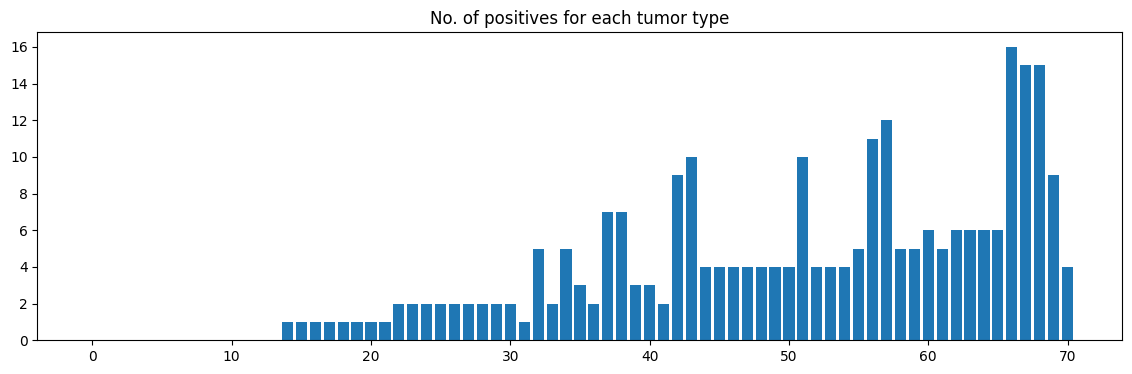

In [2]:
import matplotlib.pyplot as plt

n_of_positives = jnp.array( [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 5, 2, 5, 3, 2, 7, 7, 3, 3, 2, 9, 10, 4, 4, 4, 4, 4, 4, 4, 10, 4, 4, 4, 5, 11, 12, 5, 5, 6, 5, 6, 6, 6, 6, 16, 15, 15, 9, 4, ], dtype=jnp.float32)
group_size = jnp.array( [ 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20, 20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19, 46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20, 48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46, 47, 24, 14, ], dtype=jnp.float32)
n_rat_tumors = len(group_size)  # number of different kind of rat tumors
print(f'n_rat_tumors : {n_rat_tumors}')
plt.figure(figsize=(14, 4))
plt.bar(range(n_rat_tumors), n_of_positives)
plt.title("No. of positives for each tumor type");


Text(0.5, 1.0, 'Group size for each tumor type')

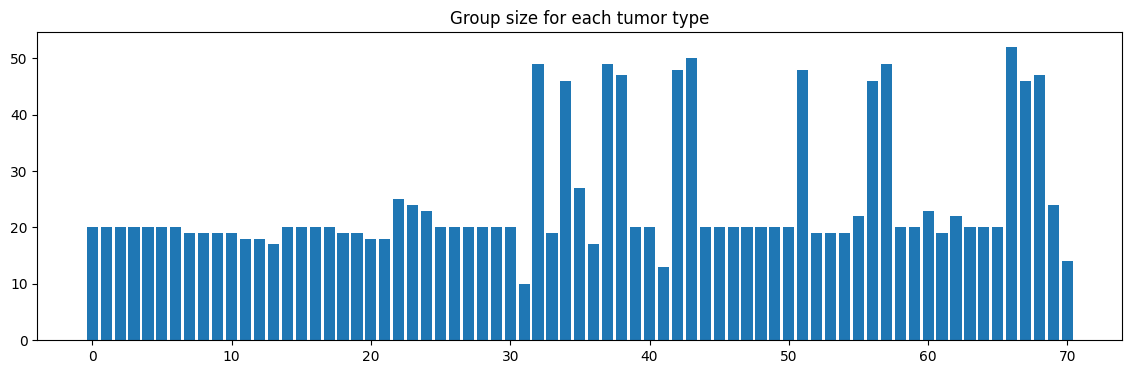

In [3]:
plt.figure(figsize=(14, 4))
plt.bar(range(n_rat_tumors), group_size)
plt.title("Group size for each tumor type")

In [4]:
import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
jacobian_fn = jax.jacfwd(jax.nn.sigmoid)
jacobian_fn_softplus = jax.jacfwd(jax.nn.softplus)

def joint_log_prob(params):
    a, b, logits = params["a"], params["b"], params["logits"]

    # HMC requires unconstrained sample space, thus it samples logits and we apply change of variable to
    # get theta from logits
    thetas = jax.nn.sigmoid(logits)
    a = jax.nn.softplus(a)
    b = jax.nn.softplus(b)
    log_det_jacob = jnp.sum(
        jax.vmap(lambda logit: jnp.log(jnp.abs(jnp.linalg.det(jacobian_fn(logit.reshape(1, 1))))))(logits)
    )

    log_det_jacob_priors = jnp.log(jnp.abs(jacobian_fn(a))) + jnp.log(jnp.abs(jacobian_fn(b)))

    # improper prior for a,b
    logprob_ab = jnp.log(jnp.power(a + b, -2.5))

    # logprob prior of theta
    logprob_thetas = tfd.Beta(a, b).log_prob(thetas).sum()

    # loglikelihood of y
    logprob_y = jnp.sum(
        jax.vmap(lambda y, N, theta: tfd.Binomial(N, probs=theta).log_prob(y))(n_of_positives, group_size, thetas)
    )
    print('joint_log_prob')
    return logprob_ab + logprob_thetas + logprob_y + log_det_jacob + log_det_jacob_priors

    # return logprob_ab + logprob_thetas + logprob_y + log_det_jacob

rng_key = jax.random.PRNGKey(82)
n_params = n_rat_tumors + 2

def init_param_fn(seed):
    """
    initialize a, b & logits
    """
    key1, key2 = jax.random.split(seed)
    return {
        "a": tfd.Uniform(0, 3).sample(seed=key1),
        "b": tfd.Uniform(0, 3).sample(seed=key2),
        "logits": tfd.Uniform(-2, 2).sample(n_rat_tumors, seed),
    }


initial_params = init_param_fn(rng_key)
print(initial_params['logits'].shape)
joint_log_prob(initial_params)

(71,)
joint_log_prob


Array(-1075.3365, dtype=float32)

In [5]:
inverse_mass_matrix = jnp.array([0.5] * (n_params))
step_size = 0.05
hmc = as_top_level_api(joint_log_prob, step_size=step_size, inverse_mass_matrix=inverse_mass_matrix, num_integration_steps=38)

# nuts kernel
n_chains = 4
keys = jax.random.split(rng_key, n_chains)
initial_states = jax.vmap(lambda seed: hmc.init(init_param_fn(seed)))(keys)
# print(initial_states)
print(initial_states.position['a'])
print(initial_states.position['b'])
print(initial_states.position['logits'].shape)
print(initial_states.logdensity.shape)
print(initial_states.logdensity_grad['a'])
print(initial_states.logdensity_grad['b'])
print(initial_states.logdensity_grad['logits'].shape)
kernel = jax.jit(hmc.step)

joint_log_prob
[2.9578853 1.7695456 0.8239317 2.3113883]
[2.046976   0.9857776  0.08438194 2.8389163 ]
(4, 71)
(4,)
[-16.367947  -10.6752405  -6.10637    -2.0536454]
[11.625502  12.048131  21.780642  -3.9693995]
(4, 71)


In [6]:
def inference_loop_multiple_chains(rng_key, kernel, initial_states, num_samples, num_chains):
    @jax.jit
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, infos = jax.vmap(kernel)(keys, states)
        return states, (states, infos)
    
    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = lax.scan(one_step, initial_states, keys)

    return (states, infos)



In [7]:
n_samples = 1500
states, infos = inference_loop_multiple_chains(rng_key, kernel, initial_states, n_samples, n_chains)
# print(states)
print(states.position['a'].shape)
print(states.position['b'].shape)
print(states.position['logits'].shape)
print(states.logdensity.shape)
print(states.logdensity_grad['a'].shape)
print(states.logdensity_grad['b'].shape)
print(states.logdensity_grad['logits'].shape)

ndim : 1
joint_log_prob
(1500, 4)
(1500, 4)
(1500, 4, 71)
(1500, 4)
(1500, 4)
(1500, 4)
(1500, 4, 71)


In [8]:
# convert logits samples to theta samples
states.position["thetas"] = jax.nn.sigmoid(states.position["logits"])
del states.position["logits"]

In [9]:
# %pip install -qq arviz

In [14]:
import arviz as az

def arviz_trace_from_states(states, info, burn_in=0):
    """
    args:
    ...........
    states: contains samples returned by blackjax model (i.e HMCState)
    info: conatins the meta info returned by blackjax model (i.e HMCinfo)
    
    returns:
    ...........
    trace: arviz trace object
    """
    print(type(states.position))
    # if isinstance(states.position, jnp.DeviceArray):  #if states.position is array of samples 
    #     ndims = jnp.ndim(states.position)
    #     if ndims > 1:
    #         samples = {"samples":jnp.swapaxes(states.position,0,1)}
    #         divergence = jnp.swapaxes(info.is_divergent, 0, 1)
    #     else:
    #         samples = states.position
    #         divergence = info.is_divergent
        
    # else: # if states.position is dict 
    samples = {}      
    for param in states.position.keys():
        ndims = len(states.position[param].shape)
        if ndims >= 2:
            samples[param] = jnp.swapaxes(states.position[param], 0, 1)[:, burn_in:]  # swap n_samples and n_chains
        elif ndims == 1:
            samples[param] = states.position[param]
            
    divergence = info.is_divergent  
    ndims_div = len(divergence.shape)
    if ndims_div >= 2:
        divergence = jnp.swapaxes(divergence, 0, 1)[:, burn_in:]
    elif ndims_div == 1:
        divergence = info.is_divergent
    # else end         
    print(samples['a'].shape)
    print(samples['b'].shape)   
    print(samples['thetas'].shape)
    trace_posterior = az.convert_to_inference_data(samples)
    trace_sample_stats = az.convert_to_inference_data({"diverging": divergence}, group="sample_stats")
    trace = az.concat(trace_posterior, trace_sample_stats)
    return trace

# make arviz trace from states
trace = arviz_trace_from_states(states, infos, burn_in=500)
summ_df = az.summary(trace)
summ_df

<class 'dict'>
(4, 1000)
(4, 1000)
(4, 1000, 71)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.782,0.373,0.081,1.460,0.016,0.011,574.0,975.0,1.00
b,6.473,1.513,3.891,9.524,0.063,0.045,592.0,916.0,1.00
thetas[0],0.043,0.039,0.000,0.113,0.001,0.001,1338.0,1146.0,1.00
thetas[1],0.042,0.038,0.000,0.114,0.001,0.001,1414.0,1109.0,1.00
thetas[2],0.042,0.038,0.000,0.114,0.001,0.001,1202.0,977.0,1.00
...,...,...,...,...,...,...,...,...,...
thetas[66],0.289,0.059,0.189,0.407,0.001,0.001,4384.0,3878.0,1.00
thetas[67],0.302,0.062,0.193,0.417,0.001,0.001,6524.0,4057.0,1.00
thetas[68],0.296,0.063,0.173,0.408,0.001,0.001,6259.0,3482.0,1.00
thetas[69],0.323,0.086,0.175,0.491,0.001,0.001,14408.0,654.0,1.01


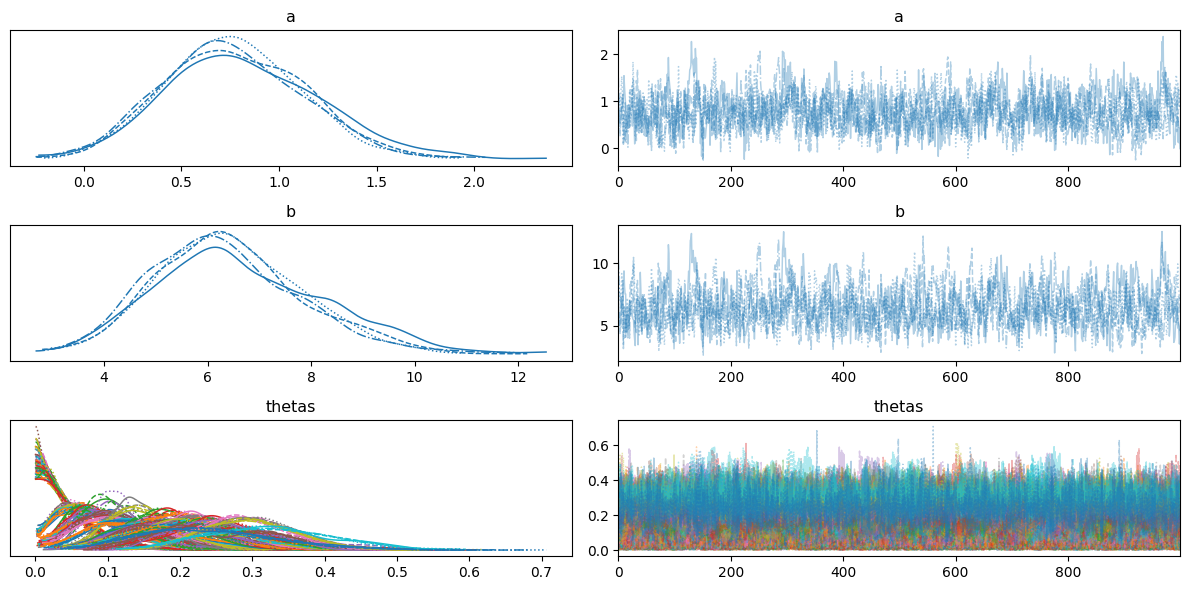

In [22]:
az.plot_trace(trace)
plt.tight_layout()

Text(0.5, 1.0, 'Theta MLE')

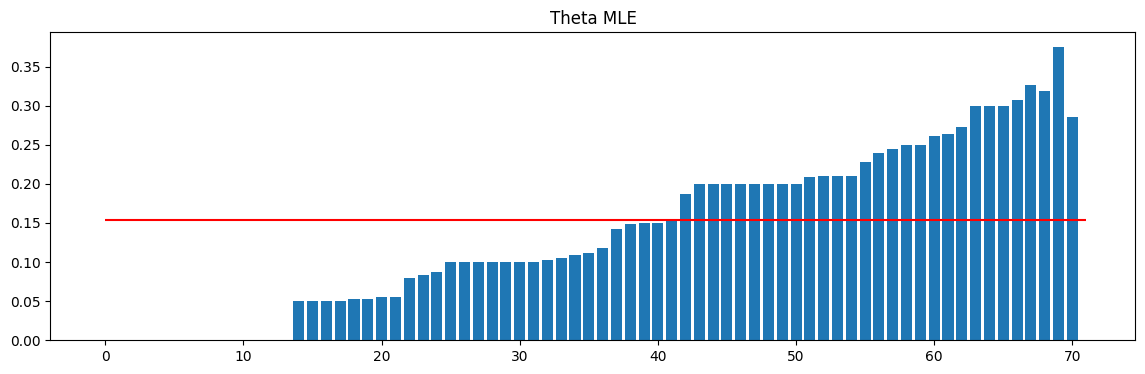

In [23]:
theta_pooled_mle = jnp.sum(n_of_positives) / jnp.sum(group_size)
theta_mle = n_of_positives / group_size

plt.figure(figsize=(14, 4))
plt.bar(range(n_rat_tumors), theta_mle)
plt.hlines(theta_pooled_mle, 0, n_rat_tumors, color="red")
plt.title("Theta MLE")

/var/folders/75/_0h54l8n6ys6k7klg1v8zggh0000gn/T/ipykernel_5147/4108032894.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  theta_population_mean = summ_df["mean"][0] / (summ_df["mean"][0] + summ_df["mean"][1])  # a/(a+b)


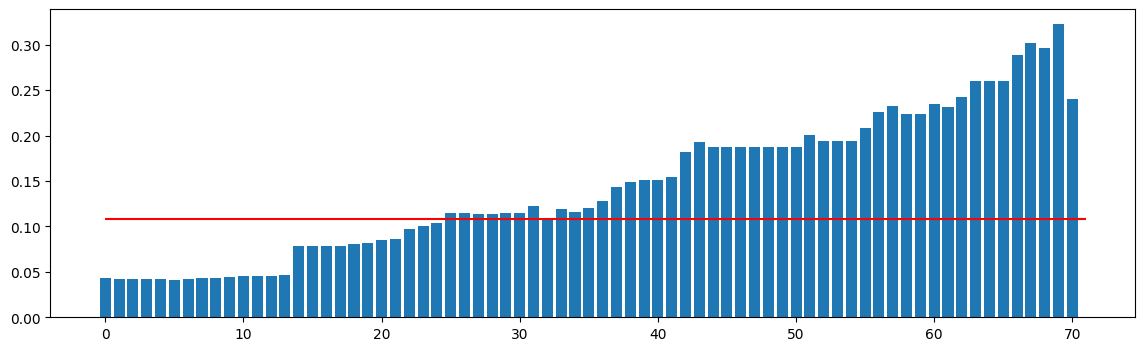

In [24]:
theta_population_mean = summ_df["mean"][0] / (summ_df["mean"][0] + summ_df["mean"][1])  # a/(a+b)

plt.figure(figsize=(14, 4))
plt.bar(range(n_rat_tumors), summ_df["mean"][2:])
plt.hlines(theta_population_mean, 0, n_rat_tumors, color="red")

/var/folders/75/_0h54l8n6ys6k7klg1v8zggh0000gn/T/ipykernel_5147/616428145.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a_mean = summ_df["mean"][0]  # concentration1 of beta
/var/folders/75/_0h54l8n6ys6k7klg1v8zggh0000gn/T/ipykernel_5147/616428145.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b_mean = summ_df["mean"][1]  # concentration0 of beta


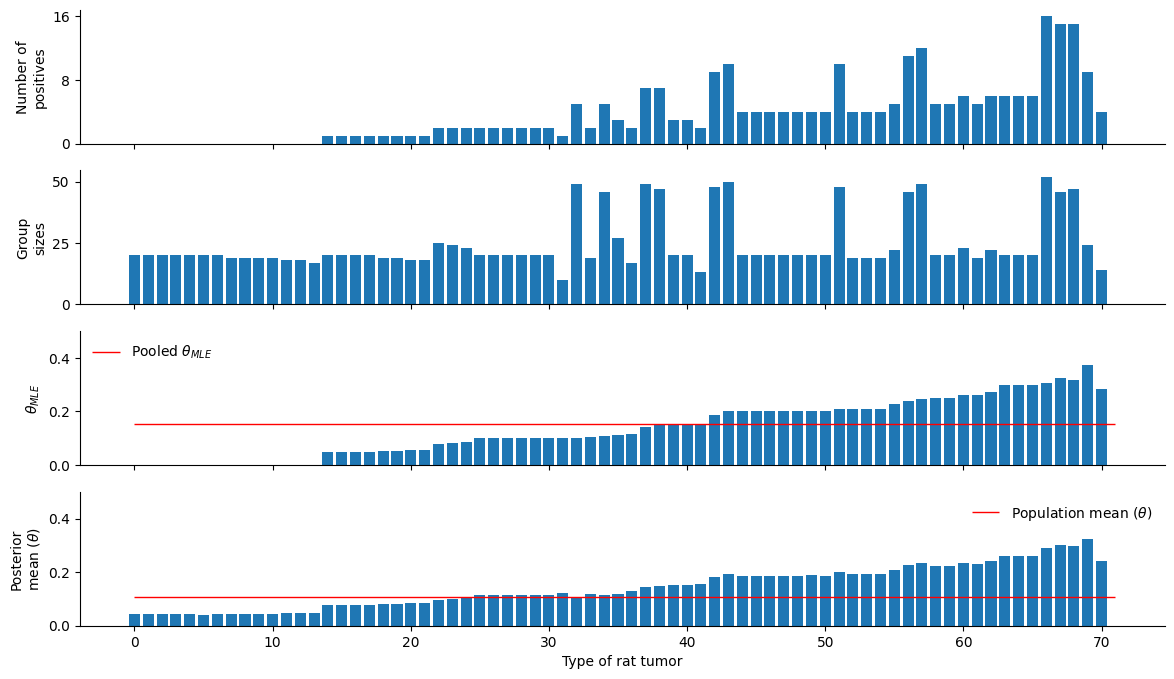

In [25]:
import seaborn as sns

FIG_SIZE = (14, 8)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=FIG_SIZE)
x = range(n_rat_tumors)

# number of positives of each tumor type
ax1.bar(x, n_of_positives)
ax1.set_ylabel("Number of\npositives")
ax1.set_yticks([0, 8, 16])

# Group size for each tumor type
ax2.bar(x, group_size)
ax2.set_ylabel("Group\nsizes")
ax2.set_yticks([0, 25, 50])

# theta MLE
theta_pooled_mle = jnp.sum(n_of_positives) / jnp.sum(group_size)
theta_mle = n_of_positives / group_size

ax3.bar(x, theta_mle)
ax3.hlines(theta_pooled_mle, 0, n_rat_tumors, color="red", label="Pooled $\\theta_{MLE}$", linewidth=1)
ax3.set_ylabel("$\\theta_{MLE}$")
ax3.set_ylim(0, 0.5)
ax3.set_yticks([0, 0.2, 0.4])
ax3.legend(frameon=False)

# Posterior mean
a_mean = summ_df["mean"][0]  # concentration1 of beta
b_mean = summ_df["mean"][1]  # concentration0 of beta

theta_population_mean = a_mean / (a_mean + b_mean)
ax4.bar(x, summ_df["mean"][2:])
ax4.hlines(theta_population_mean, 0, n_rat_tumors, color="red", label="Population mean ($\\theta$)", linewidth=1)
ax4.legend(frameon=False)
ax4.set_ylabel("Posterior\nmean ($\\theta$)")
ax4.set_xlabel("Type of rat tumor")
ax4.set_ylim(0, 0.5)
ax4.set_yticks([0, 0.2, 0.4])

sns.despine()

Text(0.5, 0, '$\\theta$')

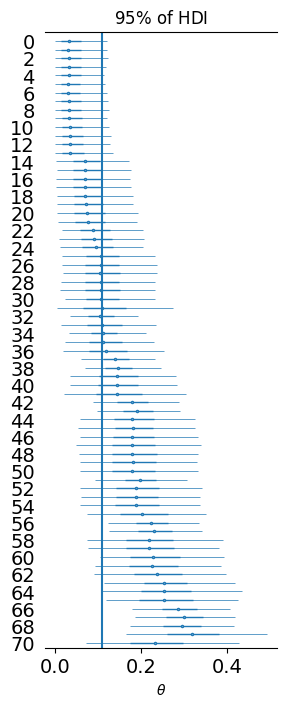

In [26]:
FIG_SIZE = (3, 8)

fig, ax = plt.subplots(figsize=FIG_SIZE)
az.plot_forest(trace, var_names="thetas", hdi_prob=0.95, combined=True, ax=ax, markersize=2, linewidth=0.5)
y_lims = ax.get_ylim()
ax.vlines(theta_population_mean, *y_lims)
ax.set_title("$95\%$ of HDI")
labels = []
for i in range(n_rat_tumors - 1, -1, -1):
    if i % 2 == 0:
        labels.append(str(i))
    else:
        labels.append("")

ax.set_yticklabels(labels)
ax.set_xlabel("$\\theta$")